In [ ]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Split all data into train test split

from sklearn.model_selection import train_test_split
robots_whole = pd.read_csv('TheDroidsYouAreLookingFor2.csv')
robots_whole.head()
X = robots_whole.drop('evil', axis = 1)
y = robots_whole['evil']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=123, stratify=y)


In [ ]:
#Descriptives
X_train.info()
X_train.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 7500 entries, 649 to 4955
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mass    7173 non-null   float64
 1   age     7285 non-null   float64
 2   cores   7239 non-null   float64
 3   RAM     7350 non-null   float64
 4   color   7430 non-null   object 
 5   power   7430 non-null   object 
dtypes: float64(4), object(2)
memory usage: 410.2+ KB


,mass,age,cores,RAM
count,7173.000000,7285.000000,7239.000000,7350.000000
mean,102.742536,37.856692,22.274624,132.103401
std,11.067033,15.186984,5.413339,20.916286
min,57.640000,4.000000,2.000000,56.000000
25%,95.170000,25.000000,18.000000,120.000000
50%,102.580000,30.000000,22.000000,136.000000
75%,109.970000,54.000000,26.000000,144.000000
max,141.920000,140.000000,42.000000,512.000000


In [4]:
print(X_train['power'].value_counts())
print(X_train['color'].value_counts())


power
battery     3649
propane     1903
hydrogen    1878
Name: count, dtype: int64
color
black    3616
red      2007
blue     1807
Name: count, dtype: int64


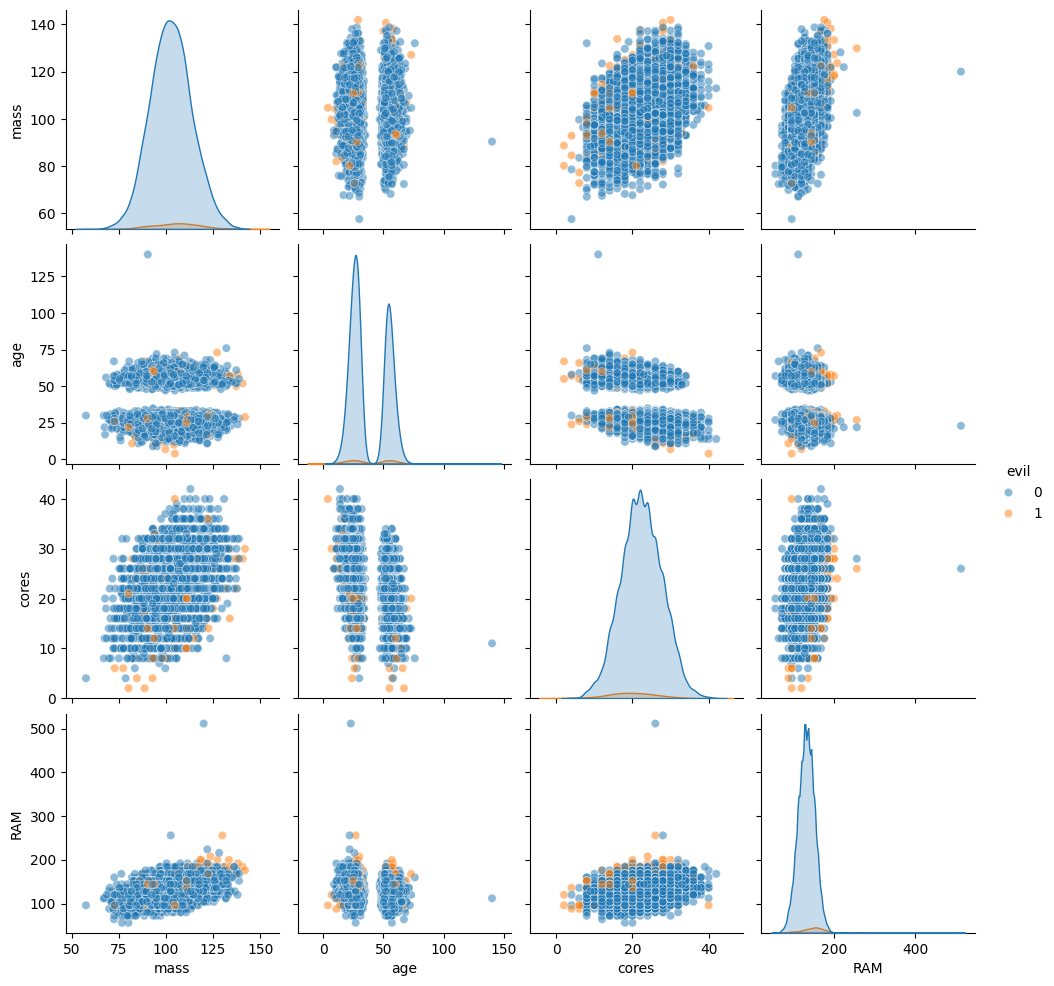

In [ ]:
# Do a pairplot

train_whole = pd.concat([X_train, y_train], axis = 1)

sns.pairplot(data= train_whole , hue = 'evil' , plot_kws = {'alpha': 0.5})
plt.show()


<class 'pandas.core.frame.DataFrame'>
Index: 7500 entries, 649 to 4955
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mass    7173 non-null   float64
 1   age     7285 non-null   float64
 2   cores   7239 non-null   float64
 3   RAM     7350 non-null   float64
 4   color   7430 non-null   object 
 5   power   7430 non-null   object 
dtypes: float64(4), object(2)
memory usage: 410.2+ KB


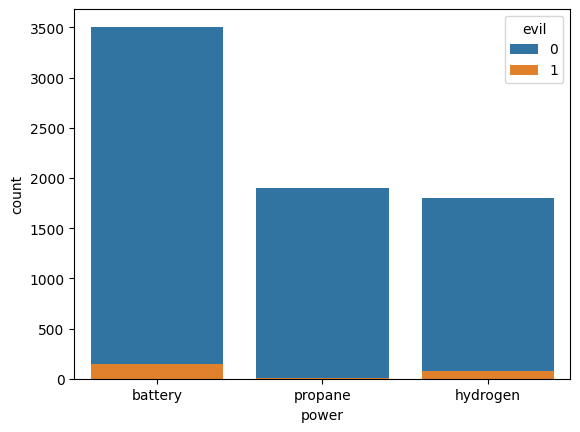

In [ ]:
# Barplot categoricals - propane powered robots are perhaps less evil?
data = train_whole[['power', 'evil']].value_counts().reset_index()
sns.barplot(x='power', y='count', hue='evil', data=data, dodge=False)


X_train.info()

In [29]:
# Preprocessing - This took forever - be grateful
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline as skPipeline
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTENC
from sklearn import set_config

# Necessary
set_config(transform_output='pandas')

# Create class to replace outliers with None
class OutlierReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, sd_thresh = 3.0):
        self.sd_thresh = sd_thresh
        
    def fit(self, X, y=None):
        self.mean_ = X.mean()
        self.sd_ = X.std()
        return self
    
    def transform(self, X):
        #transformedCol = X.apply(lambda x: x if (x - X.mean())/X.std() <= self.sd_thresh else None)
        temp_cols = pd.DataFrame(columns = X.columns.to_list())
        for col in temp_cols:
            #print(col)
            temp_cols[col] = X[col].apply(lambda x: x if (x - X[col].mean())/X[col].std() <= self.sd_thresh else None)
        #return X.apply(lambda x: x if (x - self.fit(X).mean_)/self.fit(X).sd_ <= self.sd_thresh else None)
        #print(temp_cols)
        #print(temp_cols.columns)
        return temp_cols
    

    def get_feature_names_out(self,X):

        return pd.DataFrame(X).columns.to_list()


# Split numerics and categoricals
num_features = ['mass', 'age', 'cores', 'RAM']
cat_features = ['color', 'power']

# Make a pipeline to take care of numeric vars
num_pipe = skPipeline(
    [
        ('olr', OutlierReplacer(sd_thresh=3)),
        ('scaler', StandardScaler()),
        ('knn_imp', KNNImputer(n_neighbors=5)),
     ],
)

# Pipeline for categoricals
cat_pipe = skPipeline([
    ('cat_imp', SimpleImputer(strategy = 'most_frequent'))
]
)

# Combine both into single ColumnTransformer
ct = ColumnTransformer(
    transformers=[
       ('num', num_pipe, num_features),
       ('cat', cat_pipe, cat_features) 
    ], remainder= 'passthrough', verbose_feature_names_out=False
)

# This OHE is used in the SMOTE-ing below for categorical variables
ohe1 = OneHotEncoder(sparse_output=False)


smote_ct = imbPipeline(
    [
        ('ct', ct), 
        ('smote', SMOTENC(categorical_features = cat_features, categorical_encoder= ohe1, random_state=1234))
    ]
)

# Transform through preprocess and SMOTEING
X_train_smote, y_train_smote = smote_ct.fit_resample(X_train, y_train)

# Our Categorical Cols still haven't been One Hot Encoded - do that here
ohe_ct = ColumnTransformer(
    [('ohe', OneHotEncoder(sparse_output=False), cat_features)],
    remainder='passthrough', verbose_feature_names_out=False
)

# Stick it in a pipeline for good measure
final_pipe = skPipeline(
    [
      ('ohe_pipe', ohe_ct)  
    ]
)


X_train_final= final_pipe.fit_transform(X_train_smote)


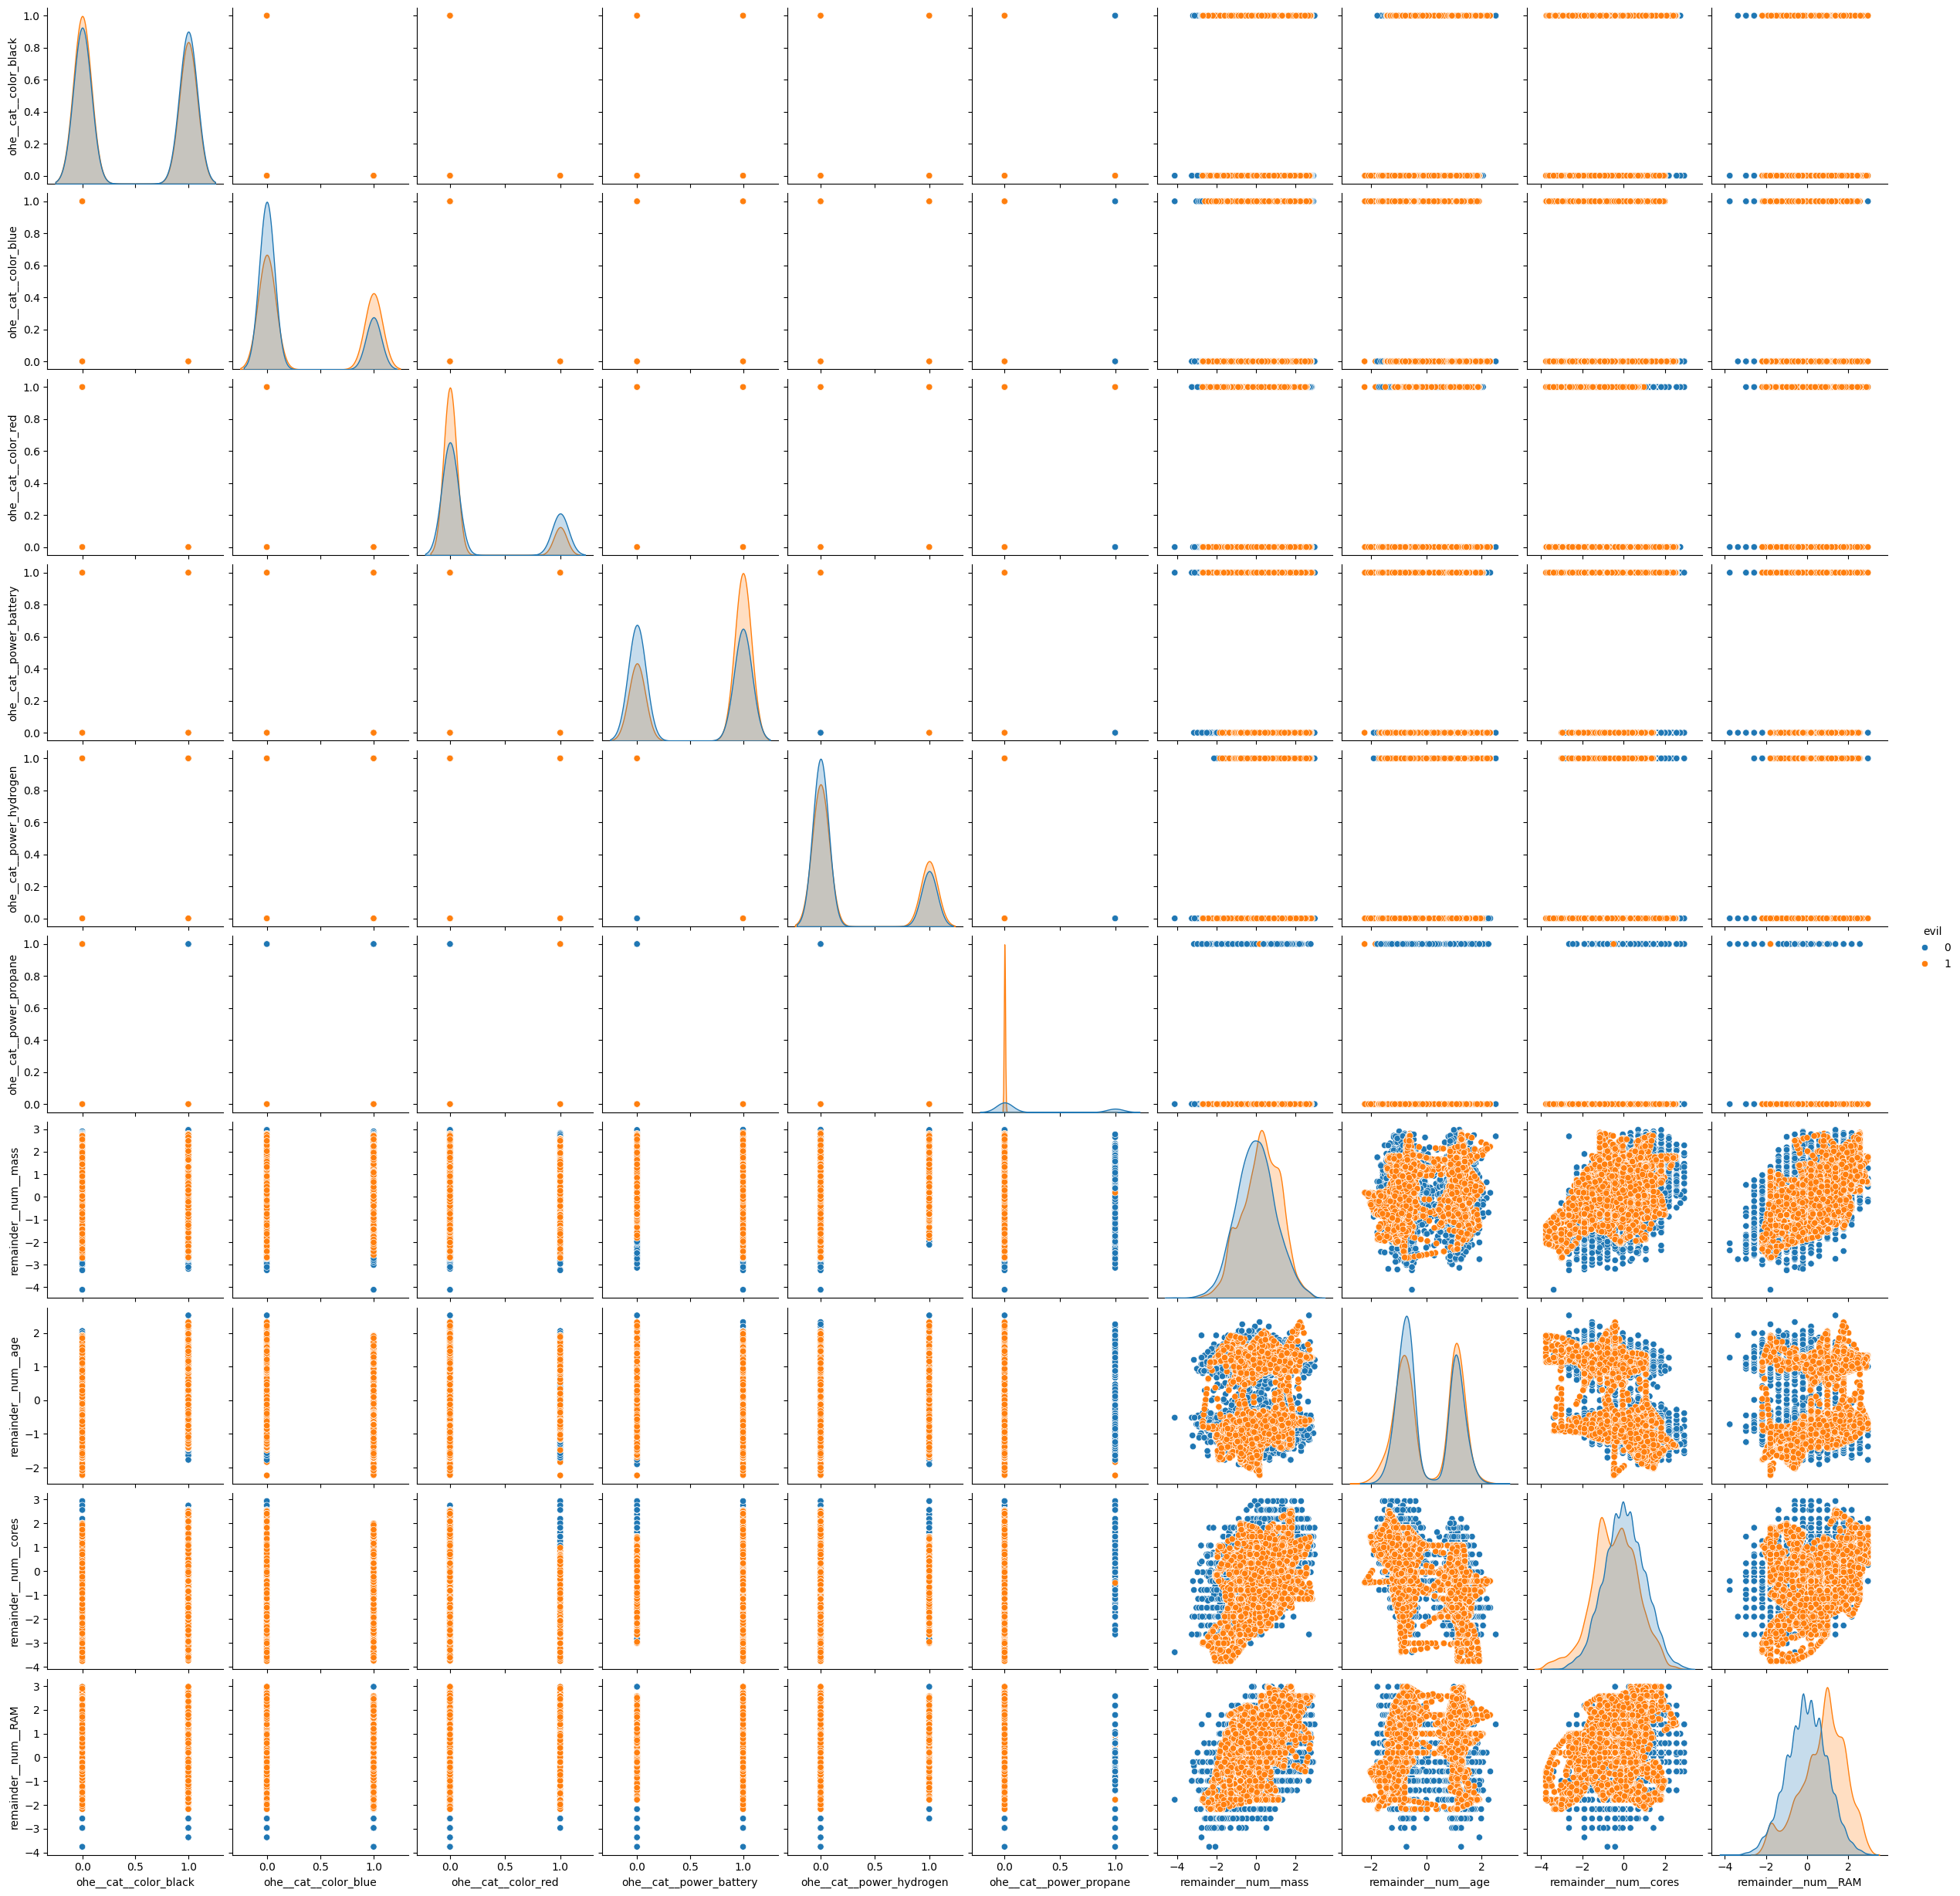

In [ ]:

#Optional additional pairplot to check - takes a while, so optional
#sns.pairplot(data = pd.concat([pd.DataFrame(X_train_final, columns = ohe_ct.get_feature_names_out()), y_train_smote], axis = 1), hue = 'evil')#, alpha = 0.5)

In [ ]:
# Set up some stuff that'll be used in all the models - this is from the old ipynb
from sklearn.model_selection import StratifiedKFold
n_folds = 5 
kf = StratifiedKFold(n_splits=n_folds, random_state=43, shuffle=True)

scoring_dict = {
     'accuracy': 'accuracy',
     'precision': 'precision',
     'recall': 'recall',
     'f1': 'f1',
     'roc_auc':'roc_auc'
}

def confusion_matrix_scorer(clf, X, y):
     y_pred = clf.predict(X)
     cm = confusion_matrix(y, y_pred)
     return {'tn': cm[0, 0], 'fp': cm[0, 1],
             'fn': cm[1, 0], 'tp': cm[1, 1]}


In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
#!pip install bayesian-optimization
lr_param_grid = [
     {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'], 
    'solver': [ 'liblinear', 'saga'],}#,

]

lr_random_grid = {
    'C': np.logspace(-3, 4, 10),
    'penalty' : ['l1', 'l2'],
    'solver' : ['liblinear', 'saga']
}



In [ ]:
# Logistic Regression Grid Search
from sklearn.linear_model import LogisticRegression
rs = 1234

lr_gs = GridSearchCV(LogisticRegression(random_state= rs, max_iter= 10000), param_grid= lr_param_grid, verbose = 3, cv = kf, scoring = scoring_dict['recall'], refit=True)
lr_gs.fit(X_train_final, y_train_smote)


#pd.DataFrame(lr_gs.cv_results_)

lr_gs.best_estimator_



Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV 1/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.775 total time=   0.0s
[CV 2/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.816 total time=   0.0s
[CV 3/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.809 total time=   0.0s
[CV 4/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.804 total time=   0.0s
[CV 5/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.786 total time=   0.0s
[CV 1/5] END ..C=0.001, penalty=l1, solver=saga;, score=0.701 total time=   0.0s
[CV 2/5] END ..C=0.001, penalty=l1, solver=saga;, score=0.737 total time=   0.0s
[CV 3/5] END ..C=0.001, penalty=l1, solver=saga;, score=0.738 total time=   0.0s
[CV 4/5] END ..C=0.001, penalty=l1, solver=saga;, score=0.741 total time=   0.0s
[CV 5/5] END ..C=0.001, penalty=l1, solver=saga;, score=0.725 total time=   0.0s
[CV 1/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.800 total time=   0.0s
[CV 2/5] END C=0.001, penalty

LogisticRegression(C=np.float64(278.2559402207126), max_iter=10000,
                   penalty='l1', random_state=1234, solver='liblinear')

In [ ]:
# Randomized Search

lr_rs = RandomizedSearchCV(LogisticRegression(random_state= rs, max_iter= 10000), param_distributions= lr_random_grid, verbose = 3, cv = kf, scoring = scoring_dict['recall'], refit= True)
lr_rs.fit(X_train_final, y_train_smote)
#pd.DataFrame(lr_rs.cv_results_)
lr_rs.best_estimator_




In [ ]:
# Stop here - this isn't quite perfected yet, but it works

from sklearn.metrics import recall_score
from bayes_opt import BayesianOptimization
import warnings
warnings.filterwarnings('ignore')
Cs = (0.001, 1000)
solvers = ['liblinear', 'saga']
penalties = ['l1', 'l2', None]

search_space = {
    "Cee": (0.001, 1000),
    "solve": (0, 1),
    "pen": (0, 1)
}

def solv_sel(solver):
    if solver == 'liblinear':
        return 0
    else:
        return 1
    
def pen_sel(penalty):
    if penalty == 'l1':
        return 0
    elif penalty == 'l2':
        return 1
    else:
        return 2

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X_train_final, y_train_smote, train_size=0.8, stratify=y_train_smote, random_state=123)

def lr_eval(Cee, pen, solve):
    params = {
        'C': Cee,
        'penalty': penalties[pen_sel(pen)],
        'solver': solvers[solv_sel(solve)]
     }
    model = LogisticRegression(**params)
    model.fit(X_train2,Y_train2)
    preds = model.predict(X_test2)
    recall = recall_score(Y_test2, preds)
    return recall


lr_bo = BayesianOptimization(f = lr_eval, 
                             pbounds = search_space,
                             random_state=1234
)

lr_bo.maximize(init_points = 5, n_iter = 10)

params = lr_bo.max['params']
params['pen'] = penalties[int(params['pen'])]
params['solve'] = solvers[int(params['solve'])]
print(params)

|   iter    |  target   |    Cee    |    pen    |   solve   |
-------------------------------------------------------------
| 1         | 0.8241    | 191.5     | 0.6221    | 0.4377    |
| 2         | 0.8247    | 785.4     | 0.78      | 0.2726    |
| 3         | 0.8241    | 276.5     | 0.8019    | 0.9581    |
| 4         | 0.8241    | 875.9     | 0.3578    | 0.501     |
| 5         | 0.8247    | 683.5     | 0.7127    | 0.3703    |
| 6         | 0.8241    | 578.6     | 0.01212   | 0.7472    |
| 7         | 0.8247    | 684.5     | 0.8015    | 0.6256    |
| 8         | 0.8247    | 0.05073   | 0.8512    | 0.3828    |
| 9         | 0.8247    | 66.25     | 0.108     | 0.9532    |
| 10        | 0.8247    | 419.7     | 0.02147   | 0.01852   |
| 11        | 0.8241    | 999.6     | 0.4389    | 0.4123    |
| 12        | 0.8247    | 472.3     | 0.895     | 0.5447    |
| 13        | 0.8247    | 743.7     | 0.005705  | 0.1918    |
| 14        | 0.8247    | 368.0     | 0.7599    | 0.3929    |
| 15    

In [ ]:
print(lr_gs.best_estimator_)
print(lr_rs.best_estimator_)
print(lr_gs.best_estimator_.score(X_train_final, y_train_smote))
print(lr_rs.best_estimator_.score(X_train_final, y_train_smote))




LogisticRegression(C=0.01, max_iter=10000, penalty='l1', random_state=1234,
                   solver='liblinear')
LogisticRegression(C=np.float64(0.005994842503189409), max_iter=10000,
                   penalty='l1', random_state=1234, solver='liblinear')
0.7655025436546129
0.7622026673999726


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004698,0.000150,0.001630,0.000049,0.001,l1,liblinear,"{'C': 0.001, 'penalty': 'l1', 'solver': 'libli...",0.775258,0.815681,0.809491,0.804124,0.786254,0.798162,0.015081,26
1,0.020765,0.002120,0.001650,0.000089,0.001,l1,saga,"{'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}",0.701031,0.737276,0.737964,0.740893,0.725086,0.728450,0.014740,28
2,0.005991,0.000074,0.001479,0.000018,0.001,l2,liblinear,"{'C': 0.001, 'penalty': 'l2', 'solver': 'libli...",0.800000,0.821183,0.834250,0.817182,0.808247,0.816173,0.011639,18
3,0.016491,0.001471,0.001445,0.000106,0.001,l2,saga,"{'C': 0.001, 'penalty': 'l2', 'solver': 'saga'}",0.768385,0.788858,0.803301,0.789003,0.775945,0.785099,0.012032,27
4,0.007042,0.000463,0.001422,0.000096,0.010,l1,liblinear,"{'C': 0.01, 'penalty': 'l1', 'solver': 'liblin...",0.809622,0.827373,0.839065,0.815808,0.824055,0.823184,0.010088,1
5,0.018060,0.001086,0.001457,0.000173,0.010,l1,saga,"{'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}",0.789691,0.804677,0.823934,0.795876,0.808935,0.804622,0.011756,24
6,0.006767,0.000142,0.001362,0.000124,0.010,l2,liblinear,"{'C': 0.01, 'penalty': 'l2', 'solver': 'liblin...",0.793814,0.803989,0.825997,0.802062,0.813746,0.807922,0.011041,23
7,0.014881,0.000279,0.001266,0.000105,0.010,l2,saga,"{'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}",0.782131,0.797799,0.820495,0.793127,0.808247,0.800360,0.013106,25
8,0.007593,0.000161,0.001216,0.000078,0.100,l1,liblinear,"{'C': 0.1, 'penalty': 'l1', 'solver': 'libline...",0.802749,0.823934,0.830124,0.805498,0.816495,0.815760,0.010471,19
9,0.017281,0.001151,0.001320,0.000090,0.100,l1,saga,"{'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}",0.800687,0.823246,0.828748,0.805498,0.815120,0.814660,0.010503,20


In [30]:
#Test Evaluation (not finished)
X_test_smote = ct.transform(X_test)

# Our Categorical Cols still haven't been One Hot Encoded - do that here


X_test_final = ohe_ct.transform(X_test_smote)
X_test_final

,color_black,color_blue,color_red,power_battery,power_hydrogen,power_propane,mass,age,cores,RAM
4731,1.0,0.0,0.0,0.0,0.0,1.0,-1.866742,1.265367,-1.905817,0.201089
3948,1.0,0.0,0.0,0.0,0.0,1.0,-0.955215,1.661675,-0.418701,-1.382805
2667,1.0,0.0,0.0,0.0,1.0,0.0,0.014527,-0.451967,0.696636,0.993037
7748,1.0,0.0,0.0,0.0,1.0,0.0,-0.373078,-0.451967,-0.604591,-0.986832
349,1.0,0.0,0.0,1.0,0.0,0.0,0.393372,1.001161,1.811972,-0.590858
...,...,...,...,...,...,...,...,...,...,...
3472,0.0,0.0,1.0,0.0,1.0,0.0,0.045732,0.869059,-0.418701,1.389010
5348,1.0,0.0,0.0,0.0,1.0,0.0,0.834080,-0.584070,-1.162259,0.597063
9803,1.0,0.0,0.0,0.0,1.0,0.0,0.470017,1.001161,-0.046922,-0.194884
3180,1.0,0.0,0.0,0.0,1.0,0.0,0.251031,-1.046429,-0.790480,0.201089


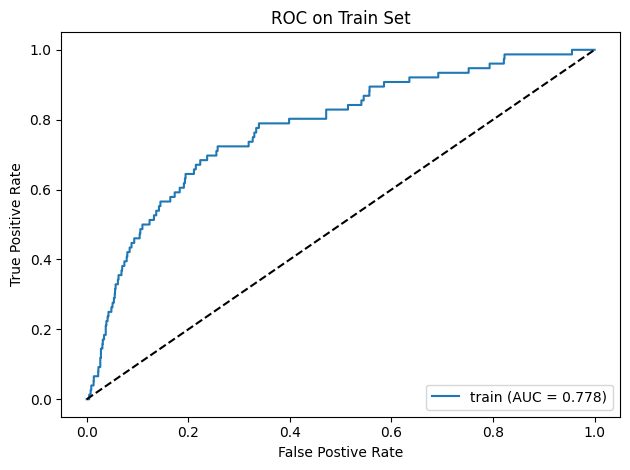

In [34]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve, auc

    #y_pred = full_results_dict[model][2].predict_proba(X = robots_test)
y_pred_gs = lr_gs.best_estimator_.predict_proba(X_test_final)
y_pred_rs = lr_rs.best_estimator_.predict_proba(X_test_final)
#print(y_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_gs[:,1])
auc_val = auc(fpr, tpr)

#y_pred2 = LogisticRegression(random_state= 1234).fit(X_train_final, y_train_smote).predict_proba(X_train_final)
#fpr2, tpr2, thresholds2 = roc_curve(y_train_smote, y_pred2[:,1])
#auc_val2 = auc(fpr2, tpr2)

plt.plot(fpr, tpr, label='{0} (AUC = {1})'.format('train', round(auc_val,3)))
#plt.plot(fpr2, tpr2, label='{0} (AUC = {1})'.format('test', round(auc_val2,3)))
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC on Train Set')
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.tight_layout()
plt.plot()
plt.show()


In [32]:
# Also stolen
def draw_cv_pr_curve(classifier, cv, X, y, title='PR Curve'):
    """
    Draw a Cross Validated PR Curve.
    Keyword Args:
        classifier: Classifier Object
        cv: StratifiedKFold Object: (https://stats.stackexchange.com/questions/49540/understanding-stratified-cross-validation)
        X: Feature Pandas DataFrame
        y: Response Pandas Series
        
    Largely taken from: https://stackoverflow.com/questions/29656550/how-to-plot-pr-curve-over-10-folds-of-cross-validation-in-scikit-learn
    """
    y_real = []
    y_proba = []

    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        # Compute ROC curve and area the curve
        precision, recall, _ = precision_recall_curve(y.iloc[test], probas_[:, 1])
        
        # Plotting each individual PR Curve
        plt.plot(recall, precision, lw=1, alpha=0.3,
                 label='PR fold %d (AUC = %0.2f)' % (i, average_precision_score(y.iloc[test], probas_[:, 1])))
        
        y_real.append(y.iloc[test])
        y_proba.append(probas_[:, 1])

        i += 1
    
    y_real = np.concatenate(y_real)
    y_proba = np.concatenate(y_proba)
    
    precision, recall, _ = precision_recall_curve(y_real, y_proba)

    plt.plot(recall, precision, color='b',
             label=r'Precision-Recall (AUC = %0.2f)' % (average_precision_score(y_real, y_proba)),
             lw=2, alpha=.8)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

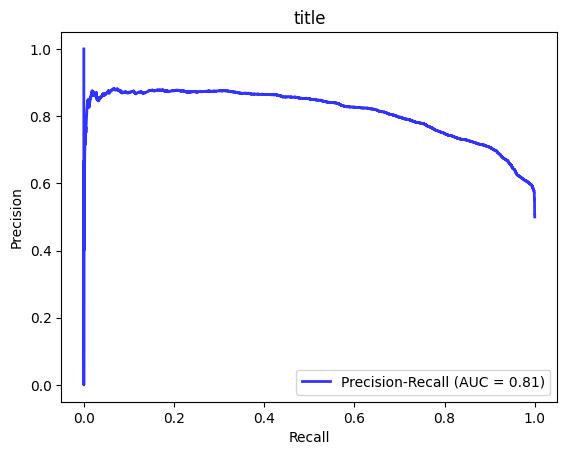

In [43]:
probas_ = lr_gs.best_estimator_.fit(X_train_final, y_train_smote).predict_proba(X_train_final)
# Compute ROC curve and area the curve
precision, recall, _ = precision_recall_curve(y_train_smote, probas_[:, 1])

# Plotting each individual PR Curve
#plt.plot(recall, precision, lw=1, alpha=0.3,
#            label='PR fold %d (AUC = %0.2f)' % ('lr', average_precision_score(y_train_smote, probas_[:, 1])))

# y_real.append(y_train_smote)
# y_proba.append(probas_[:, 1])



# y_real = np.concatenate(y_real)
# y_proba = np.concatenate(y_proba)

# precision, recall, _ = precision_recall_curve(y_real, y_proba)

plt.plot(recall, precision, color='b',
        label=r'Precision-Recall (AUC = %0.2f)' % (average_precision_score(y_train_smote, probas_[:, 1])),
        lw=2, alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('title')
plt.legend(loc="lower right")
plt.show()